In [1]:

import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import syndat
import scipy.stats as stat
import matplotlib as mpl
#import syndat.plot as myplt
import sys
from matplotlib.pyplot import *


sammy_directory =  '/Users/nwx/Documents/GitHub/nuc_syndat/synthetic_data/Ta181'
#"/Users/noahwalton/Documents/GitHub/nuc_syndat/synthetic_data/Ta181"
# #os.path.realpath('./synthetic_data/Ta181')




In [2]:
%matplotlib notebook

In [3]:
# redux parms ---  experimentally unique values

# =============================================================================
# # constants and uncertainties
# =============================================================================
n = .12 # need to pull this from the endf evaluation
trig_o = 9760770 # number of linac pulses for open 
# trig_i = 18479997 
flux_mag = 1e5 # what is a reasonable flux magnitude??
detector_efficiency = 1
tof_dist = 35.185 # m   !!! not the proper tof_distance, but I need the erange to match up
t0 = 3.326

# assuming 1% uncertainty of these values
m1 = 1; dm1 = m1*0.016
m2 = 1; dm2 = m2*0.008
m3 = 1; dm3 = m3*0.018
m4 = 1; dm4 = m4*0.005
alpha = [m1,m2,m3,m4]; d_alpha = [dm1,dm2,dm3,dm4]

a = 582.8061256946647; da = np.sqrt(1.14174241e+03)
b = 0.0515158865500879; db = np.sqrt(2.18755273e-05)
# a,b COV 1.42405866e-01

# sample in
k_i = 0.563; dk_i = k_i*0.0427
# b0_i = 10.0; db0_i = b0_i*0.01
b0_i,db0_i = 9.9,0.1
# sample out
K_o = 1.471; dK_o = K_o*0.0379
# B0_o = 13.4; dB0_o = B0_o*0.01
B0_o,dB0_o = 13.4,0.7

In [4]:
# =============================================================================
# # open count rate 
# =============================================================================
# # estimate true underlying, raw, open count data with a wide gaussian flux
# cts_o_true = syndat.exp_effects.generate_open_counts(energy, flux_mag, 50, 100)

# or: import open count rate from RPI Ta-181 experiment:
odat = pd.read_csv(os.path.join(sammy_directory,'rpi-open-ta181.csv'), sep=',') #pd.read_csv(os.path.join(sammy_directory,'ta181opencountrate.dat'), sep=',')
odat = odat[odat.tof >= t0]
odat.reset_index(drop=True, inplace=True)
odat['E'] = syndat.exp_effects.t_to_e((odat.tof+t0)*1e-6, tof_dist, True) 

# cts_o_true = odat.counts[4:]
# tof = odat.tof[4:]  #!!! tof must be in microseconds to have the proper magnitude that Jesse normed to
# energy = odat.E[4:]

# get bin width vector from tof o
# bw = np.flipud(np.diff(np.flipud(tof)))
# bw = np.insert(bw,0,bw[0]) # assumes given leading tof edge
odat['bw'] = odat.bin_width*1e-6 # must we convert to microseconds
# bw = odat.bw[4:]

# background function - Jesse has normalized alread, tof mus be micro-seconds
def bkg_func(ti,a,b):
    return a*np.exp(ti*-b)
Bi = bkg_func(odat.tof,a,b)
tof=odat.tof


# syndat.sammy_interface.write_estruct_file(energy, "/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/Research Projects/Resonance Fitting/summer_2022/Ta181_sammy/estruct")


In [5]:
tof

0           3.6896
1           4.5088
2           5.3280
3           6.1472
4           6.9664
           ...    
16041    2153.4496
16042    2205.8784
16043    2258.3072
16044    2310.7360
16045    2363.1648
Name: tof, Length: 16046, dtype: float64

<IPython.core.display.Javascript object>


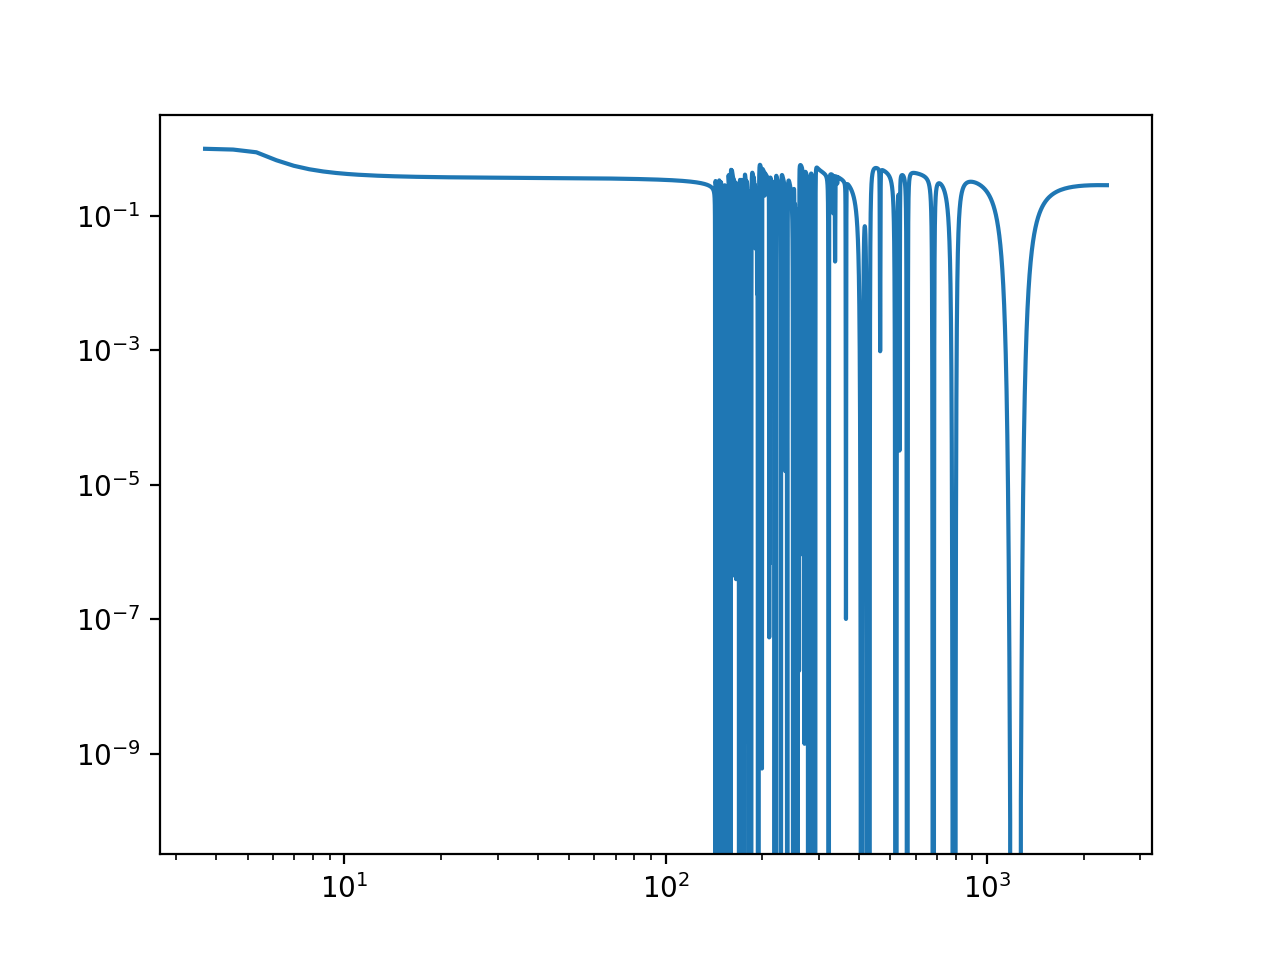

In [6]:
#%% read sammy lst for experimentally corrected theoretical cross section

sam = syndat.sammy_interface.readlst(os.path.join(sammy_directory,'SAMMY.LST'))
# sam = pd.read_csv("/Users/noahwalton/research_local/resonance_fitting/summer_2022/ogsam.csv", sep=',', names=['E','exp_xs','exp_xs_unc','theo_xs','theo_xs_bayes','exp_trans','exp_trans_unc','theo_trans', 'theo_trans_bayes'])
# could test that energy structure lines up the same
# energy = sam['E'] 

T_theo = np.flipud(sam.theo_trans)
c_i = pd.DataFrame()
c_i['theo_trans'] = T_theo

plt.figure()
plt.plot(tof,T_theo)
plt.xscale('log'); plt.yscale('log')

<IPython.core.display.Javascript object>


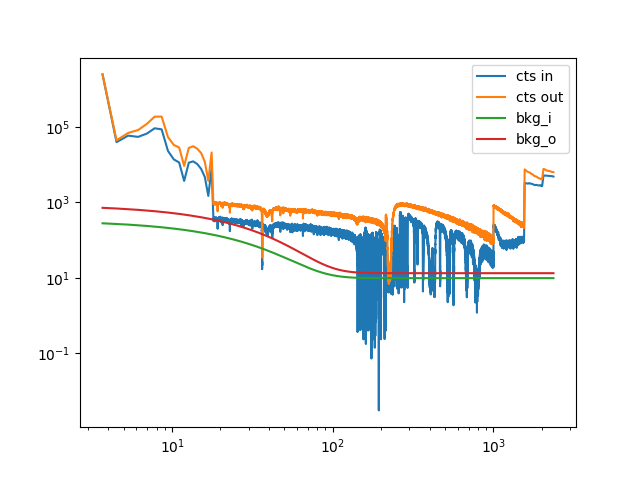

In [17]:
#%%
# =============================================================================
# # generate noisy, raw, sample in count data with statistical unc from a true underlying transmission
# =============================================================================

c_i, odat = syndat.exp_effects.generate_raw_count_data(c_i, odat, trig_o, k_i,K_o, Bi, b0_i, B0_o, alpha)

#calculate open count rates
# Cr, dCr = syndat.exp_effects.cts_to_ctr(odat.counts, np.sqrt(odat.counts), odat.bw, trig_o) # cts_o/(bw*trig)

# Cr = np.array(odat.counts/(odat.bw*trig_o))
# partial = np.array(1/(odat.bw*trig_o))
# dCr = [np.sqrt((partial[i]**2)*dc**2) for i,dc in enumerate(np.sqrt(odat.counts))]


# # calculate sample in count rate from theoretical transmission, bkg, m,k, and open count rate
# [m1,m2,m3,m4] = alpha
# cr = (c_i.theo_trans*(m3*Cr - m4*K_o*Bi - B0_o) + m2*k_i*Bi + b0_i)/m1

# # calculate sample in counts, noise, and uncertainty
# c = cr*odat.bw*trig_o 
# c_i['c'] = np.where(c<0,10,c)
# c_i['dc'] = np.sqrt(c_i.c)
# nc = syndat.exp_effects.gaus_noise(c_i.c,c_i.dc) # will create some negative counts, force to zero
# c_i['nc'] = np.where(nc<0, 10, nc) # replace negative counts with 0
# c_i['dnc'] = np.sqrt(nc)



figure()
plot(tof,c_i.nc, label='cts in'); 
plot(tof,odat.counts, label='cts out'); 
xscale('log'); yscale('log')
plt.plot(tof, k_i*Bi+b0_i, label='bkg_i')
plt.plot(tof, K_o*Bi+B0_o, label='bkg_o')
legend()

In [8]:
min(c_i.c)


2.475408880062656

,theo_trans,c,dc,nc,dnc,cps,ncps,dncps
0,0.999468,2.469620e+06,1571.502489,2.469521e+06,1571.470950,308856.057655,308843.660606,196.531575
1,0.973870,4.002154e+04,200.053851,4.014037e+04,200.350628,5005.181236,5020.042495,25.056285
2,0.886917,5.906021e+04,243.023067,5.852890e+04,241.927467,7386.198432,7319.751429,30.255975
3,0.675679,5.484730e+04,234.195004,5.459471e+04,233.655114,6859.322602,6827.733452,29.221417
4,0.558587,6.683416e+04,258.523030,6.632562e+04,257.537614,8358.425029,8294.826619,32.208214
...,...,...,...,...,...,...,...,...
16041,0.287233,5.095144e+03,71.380279,4.952784e+03,70.376017,9.956403,9.678217,0.137522
16042,0.287703,5.075417e+03,71.241961,5.064729e+03,71.166907,9.917854,9.896969,0.139067
16043,0.287810,5.020754e+03,70.857279,5.103026e+03,71.435467,9.811038,9.971805,0.139592
16044,0.287618,4.952111e+03,70.371235,4.760762e+03,68.998272,9.676902,9.302987,0.134829


<IPython.core.display.Javascript object>


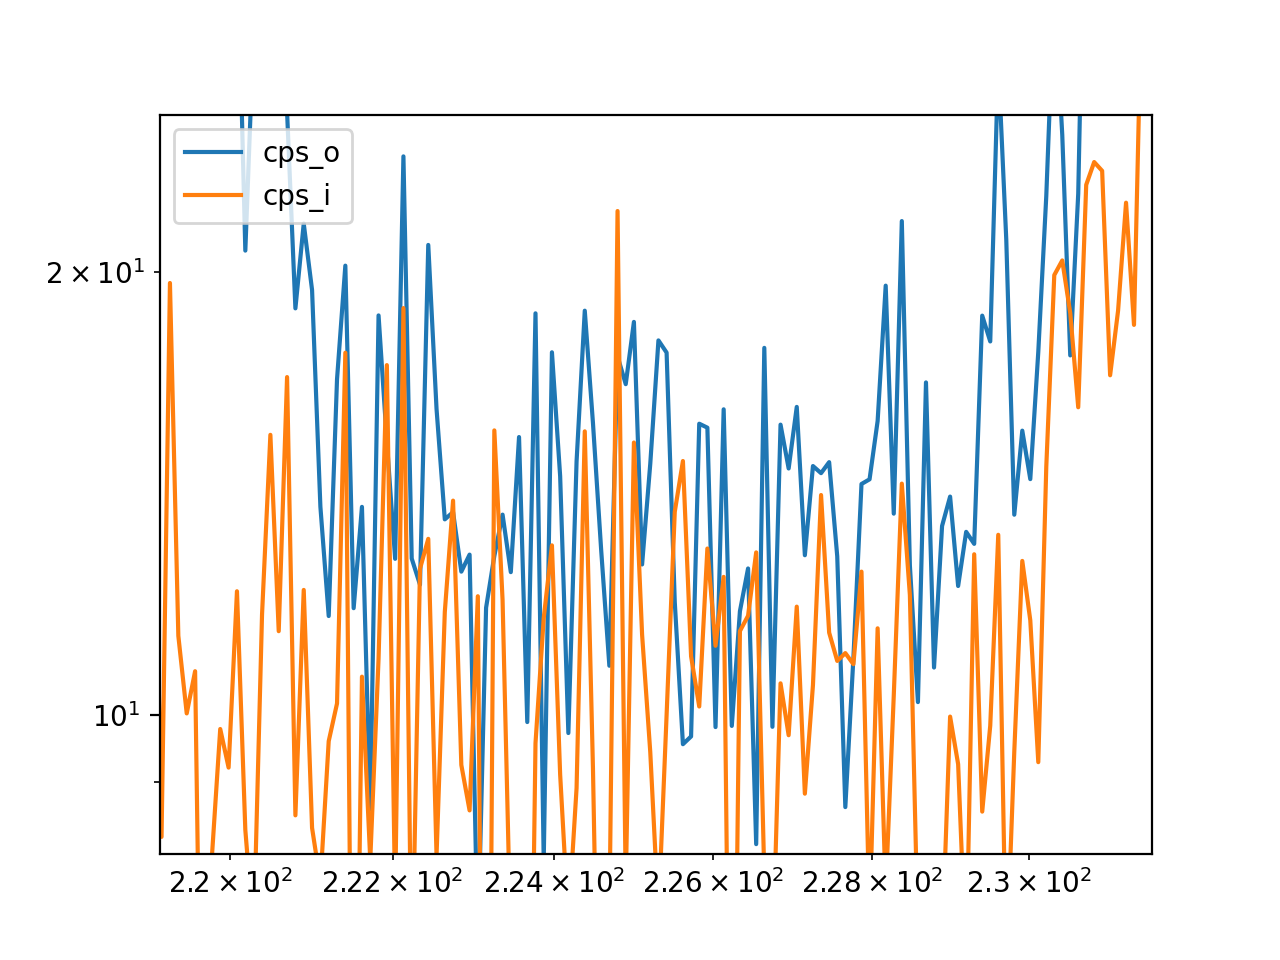

In [9]:
# calculated sample in count rate clean and noisey

c_i['cps'], c_i['dcps'] = syndat.exp_effects.cts_to_ctr(c_i.c, c_i.dc, odat.bw, trig_o)
c_i['ncps'], c_i['dncps'] = syndat.exp_effects.cts_to_ctr(c_i.nc, c_i.dnc, odat.bw, trig_o)

figure()
plt.plot(tof,odat.cps,label='cps_o')
plt.plot(tof,c_i.ncps, label='cps_i')
xscale('log'); yscale('log')
legend()


In [23]:
# # take a noisy measurement of raw open count data with uncertainty
# cts_o = cts_o_true # syndat.exp_effects.generate_open_counts(energy, flux_mag, 50, 100)
# cts_o_se = np.sqrt(cts_o) # statistical error from poisson counting stats
# noisy_cts_o = syndat.exp_effects.gaus_noise(cts_o, cts_o_se)
# noisy_cts_o_se = np.sqrt(noisy_cts_o)

# plt.figure()
# plt.plot(tof,odat.cps, label='ctr_o')
# plt.plot(tof,c_i.cps, label='ctr_in')
# # plt.plot(tof,odat.counts, label='cts_o')
# # plt.plot(tof,c_i.nc, label='cts_i')
# plt.plot(tof, k_i*Bi + b0_i, label="bkg_i")
# plt.plot(tof, K_o*Bi + B0_o, label="bkg_o")
# # plt.plot(tof,T_theo, label=r'$T_{theo}$')
# # plt.plot(tof,cts_o_se/cts_o*100, label='o')
# # plt.plot(tof,noisy_cts_o_se/noisy_cts_i*100, label='in')
# # plt.ylim([1e-3,3e5])
# plt.legend()
# plt.xscale('log'); plt.yscale('log')

In [ ]:
# plt.figure()
# # plt.plot(tof,np.sqrt(cts_o_true)/cts_o_true*100,label='dcts_o')
# plt.plot(tof,dnc/nc*100,label='dcts_i')
# # plt.plot(tof,dCr/Cr*100,label='dctr_o')
# plt.plot(tof,dncr/ncr*100,label='dctr_i')
# plt.legend()
# plt.xscale('log'); plt.yscale('log')


In [ ]:
#%% Plotting only

# this section is for plotting only, the next section does these calculations under the hood
# but we want out count rates for plotting

# ctr_o, ctr_o_se = syndat.exp_effects.cts_to_ctr(cts_o, cts_o_se, bw, trig) 
# ctr_i, ctr_i_se = syndat.exp_effects.cts_to_ctr(noisy_cts_i, noisy_cts_i_se, bw, trig)
# # Tn = syndat.exp_effects.transmission(ctr_i,ctr_o, Bi, k_i,K_o, b0_i,B0_o, alpha)

# #sum(C_o['dco'][0:-5]-ctr_o_se)

# #C_o
# plt.figure()
# plt.plot(tof,ctr_o_se/ctr_o)
# plt.plot(tof,ctr_i_se/ctr_i, label='in')
# plt.legend()
# plt.xscale('log'); plt.yscale('log')


In [ ]:
# plt.figure()
# #plt.errorbar(tof,ctr_i, yerr=ctr_i_se,label='cr_i',color='cornflowerblue',ecolor='cornflowerblue',elinewidth=0.5,capsize=2, fmt='.', ms=1)
# #plt.errorbar(tof,ctr_o, yerr=ctr_o_se,color='orange',ecolor='orange',elinewidth=0.5,capsize=2, fmt='.', ms=1)
# plt.plot(tof,ctr_i_se/ctr_i*100, label='in')
# plt.plot(tof,ctr_o_se/ctr_o*100, label='out')
# # plt.plot(tof, ctr_i, lw=1, label='cr_s')
# # plt.plot(tof, ctr_o, lw=1, label='cr_o')
# # plt.plot(tof, T_theo, label='Theoretical T', c='k', alpha=0.5)

# plt.legend()
# #plt.ylim([1e-3,1e5])
# #plt.xlim([2e2, 2.5e2])
# plt.xscale('log'); plt.yscale('log')

# plt.title('Count Rate comparison with overlayed theoretical transmission')
# #plt.show(); plt.close()




In [32]:
#%% Reduce the noisy, raw count data

# compile systematic uncertainties #[dks,dko,db0s,db0o,dalpha1,dalpha2,dalpha3,dalpha4]
sys_unc = np.append([da,db,dk_i,dK_o,db0_i,dB0_o], d_alpha)
# %time
# #%%timeit
# # reduce raw, noisy count data with statistical uncertainties to transmission data with propagated uncertainty
Tn, dT, CovT = syndat.exp_effects.reduce_raw_count_data(tof, c_i.nc, odat.counts, c_i.dnc, np.sqrt(odat.counts), \
                                                        odat.bw, trig_o, a,b, k_i,K_o, Bi, b0_i,B0_o, alpha, sys_unc)
# # calculate the correlation matrix
CorT = np.corrcoef(CovT)


# # calculate count rate and propagate uncertainty
# Cr, dCr = syndat.exp_effects.cts_to_ctr(np.array(odat.counts), np.array(np.sqrt(odat.counts)), np.array(odat.bw), trig_o) 
# cr, dcr = syndat.exp_effects.cts_to_ctr(np.array(c_i.nc), np.array(c_i.dnc), np.array(odat.bw), trig_o)


# figure()
# plt.plot(tof,(dcr/cr)*100,label='% unc')
# plt.plot(tof,cr, label='cps')
# xscale('log'); yscale('log')
# legend()
# sum(cr-c_i.ncps) # same thing!

In [37]:

# calculate transmission
# Tn = syndat.exp_effects.transmission(cr,Cr, Bi, k_i,K_o, b0_i,B0_o, alpha)
# # propagate uncertainty to transmission
# CovT, CovT_stat, CovT_sys = syndat.exp_effects.get_covT(tof, cr,Cr, dcr,dCr, a,b, k_i,K_o, Bi, b0_i,B0_o, alpha, sys_unc)
# dT = np.sqrt(np.diagonal(CovT))


# c = np.array(cr); dc = np.array(dcr)
# C = np.array(Cr); dC = np.array(dCr)
# tof = np.array(tof)
# Bi = np.array(Bi)
# # derivatives
# D = alpha[2]*Cr - alpha[3]*K_o*Bi - B0_o
# N = alpha[0]*cr - alpha[1]*k_i*Bi - b0_i
# # construct statistical covariance and jacobian
# dTi_dci = alpha[0]/D
# dTi_dCi = N*alpha[2]/D**2
# diag = (dc**2)*(dTi_dci**2) + (dC**2)*(dTi_dCi**2)
# CovT_stat = np.diag(diag)
# # construct systematic covariance and jacobian
# Cov_sys = np.diag(sys_unc**2)
# # print("WARNING: Need to update getCov function to take a/b covariances, currently it says cov = var*var")
# Cov_sys[0,1] = 1.42405866e-01 # sys_unc[0]*sys_unc[1]  
# Cov_sys[1,0] = 1.42405866e-01 #sys_unc[1]*sys_unc[0]        
# # systematic derivatives
# dTi_da = -(k_i*alpha[1]*D+K_o*alpha[3]*N)*np.exp(-b*tof) / (D**2)
# dTi_db = (k_i*alpha[1]*D)*Bi*tof / (D**2)
# dTi_dk = -alpha[1]*Bi/D**2
# dTi_dK = N*alpha[3]*Bi/D**2
# dTi_db0 = -1/D
# dTi_dB0 = N/D**2
# dTi_dalpha = [ c/D, -k_i*Bi/D, -C*N/D**2, K_o*Bi*N/D**2 ]
# # dT_dsys = np.append([dTi_da, dTi_db, dTi_dk, dTi_dK, dTi_db0, dTi_dB0], dTi_dalpha)
# Jac_sys = np.array([dTi_da, dTi_db, dTi_dk, dTi_dK, dTi_db0, dTi_dB0, dTi_dalpha[0], dTi_dalpha[1],dTi_dalpha[2],dTi_dalpha[3]])
# # calculate covariance of output
# CovT_sys = Jac_sys.T @ Cov_sys @ Jac_sys
# CovT = CovT_stat + CovT_sys

# CorT = np.corrcoef(CovT)


In [36]:
# 
# figure()
# plot(tof,np.sqrt(np.diag(CovT_stat)))
# xscale('log'); yscale('log')


In [38]:
# CovT_sys
# figure()
# plot(tof,np.sqrt(np.diag(CovT_sys)))
# xscale('log'); yscale('log')


<IPython.core.display.Javascript object>


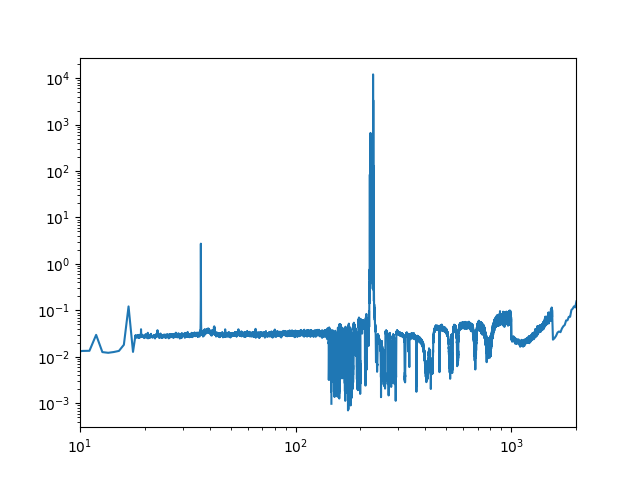

In [39]:

figure()
plot(tof,np.sqrt(np.diag(CovT)))
xlim([1e1,2e3])
xscale('log'); yscale('log')


<IPython.core.display.Javascript object>


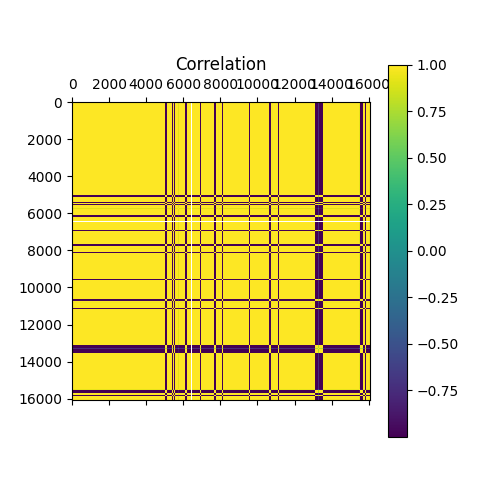

Text(0.5, 1.0, 'Correlation')

In [43]:

# figure()
matshow(CorT)
colorbar()
title('Correlation')


<IPython.core.display.Javascript object>


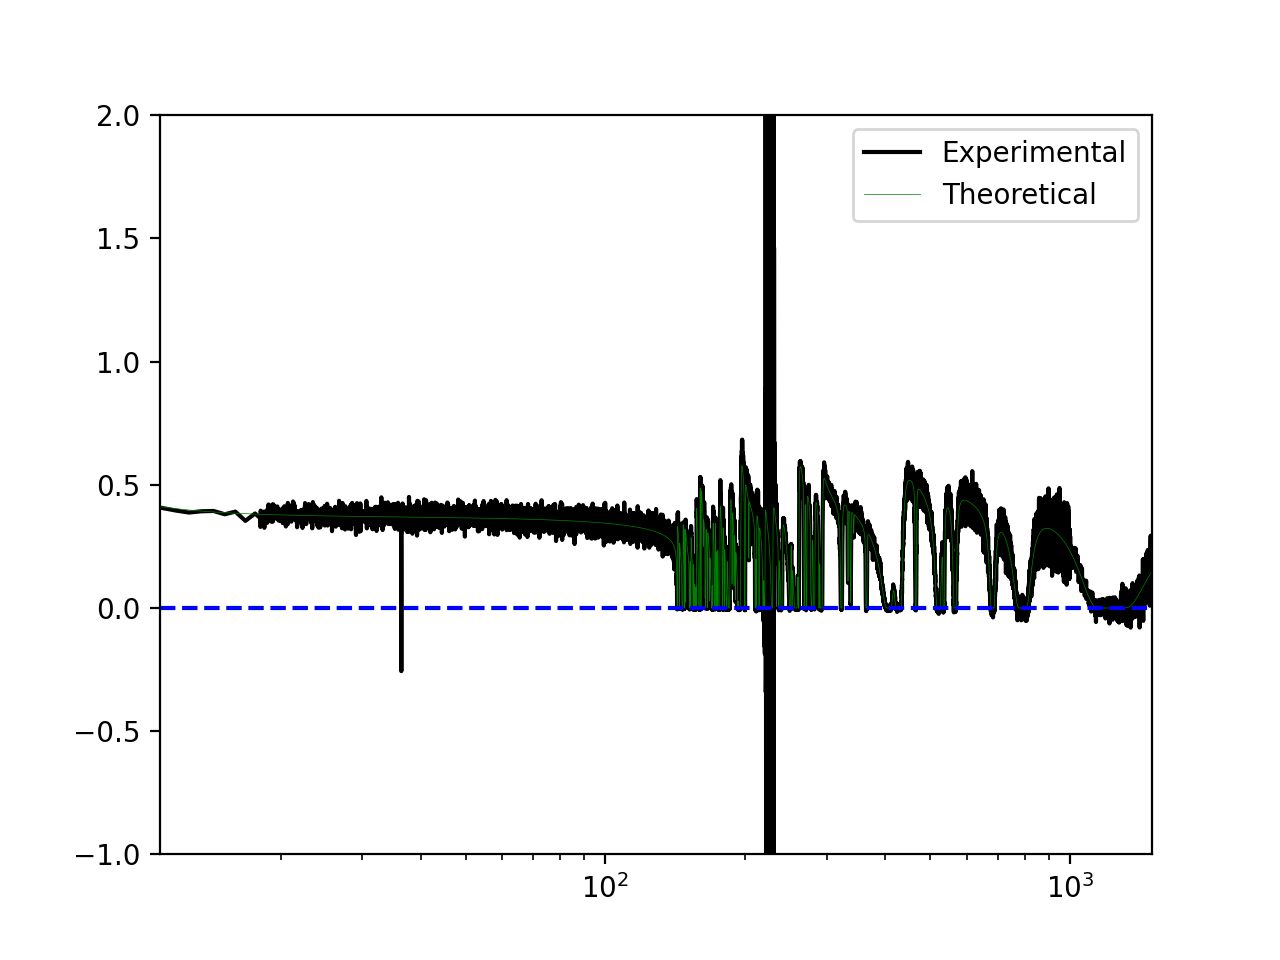

In [55]:
# syndat.plot.exp_theo(tof, Tn, dT, T_theo)
plt.figure()
# plt.errorbar(tof,Tn, yerr=dT,color='r',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
plt.plot(tof, Tn, label='Experimental', ms=1, c='k')
plt.plot(tof, T_theo, label='Theoretical', c='g', lw=0.25)
plt.axhline(0.0,c='b',ls='--')

plt.legend()
plt.ylim([-1,2])
plt.xlim([11,1500])
plt.xscale('log'); 

<IPython.core.display.Javascript object>


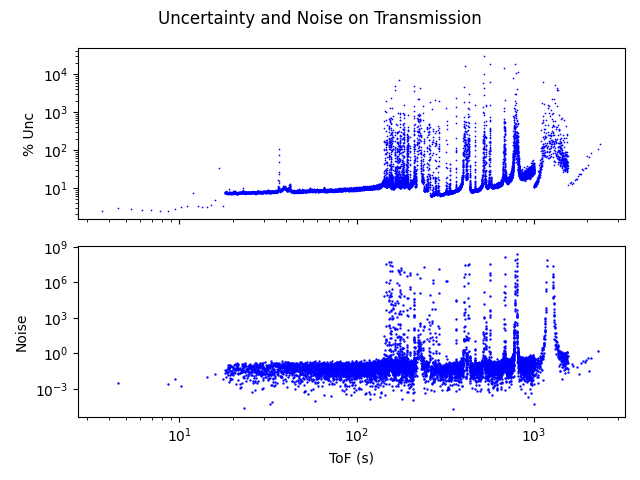

In [49]:
# syndat.plot.unc_noise(tof, dT, T_theo, Tn, ctr_o, ctr_i)

#fig, ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios':[2,1]}) # , figsize=(12,5)
fig, (ax1, ax3) = plt.subplots(2, gridspec_kw={'height_ratios': [1, 1]}, sharex=True) # , figsize=(12,5)
# plt.rcParams['figure.dpi'] = 500
# ax1 = ax[0,0]; ax2=ax[1,0]; ax3=ax[0,1]; ax4=ax[1,1]

ax1.scatter(tof, dT/Tn*100, lw=0.5, color='b', s=0.5, zorder=2)
#ax1.set_ylim([0,2])
ax1.set_yscale('log')
ax1.set_ylabel('% Unc'); #('$\sigma$')('$\delta$T')

# ax2.plot(tof,ctr_o, lw= 0.5, c='orange', label=r'$ctr_{out}$')
# ax2.plot(tof,ctr_i, lw= 0.5, c='cornflowerblue', label=r'$ctr_{in}$')
# ax2.plot(tof,T_theo, lw= 0.5, c='g', label=r'$T_{theo}$')
# ax2.set_yscale('log')
# ax2.set_ylim([1e-5,3e5])
# ax2.set_ylabel(r'$ctr_o$')
# ax2.legend()
# =============================================================================
#     ax25 = plt.twinx(ax2)
#     ax25.plot(tof,T_theo, lw= 0.5, c='g', label=r'$T_{theo}$')
#     ax25.set_ylabel(r'$T_{theo}$')
#     ax25.set_yscale('log')
#     ax25.set_ylim([1e-3,1e1])
# =============================================================================

rel_se = (Tn-T_theo)/T_theo
ax3.scatter(tof, rel_se, s=0.5, c='b')
#ax3.set_ylim([0,1])
ax3.set_ylabel('Relative Noise')
ax3.set_yscale('log')

#plt.xlim([1e2,2e3])

plt.xscale('log')
plt.xlabel('ToF (s)');
plt.suptitle('Uncertainty and Noise on Transmission')
plt.tight_layout()
#plt.show(); plt.close()

<IPython.core.display.Javascript object>


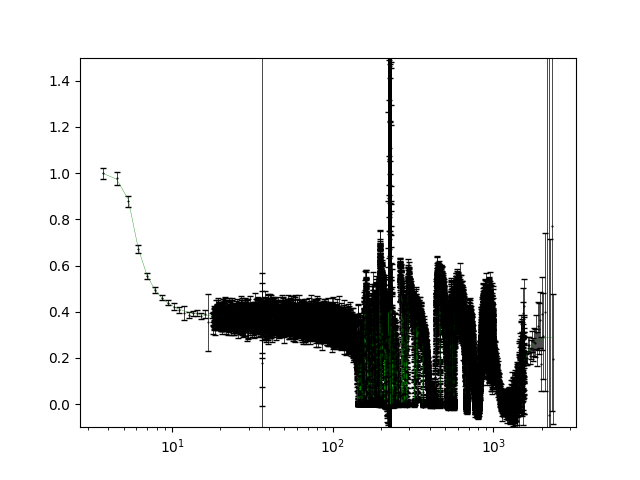

In [53]:
figure()
plt.errorbar(tof,Tn, yerr=dT,color='k',ecolor='k',elinewidth=0.5,capsize=2, fmt='.', ms=1)
#plt.scatter(tof, Tn, label='Experimental', s=1, c='k')
plt.plot(tof, T_theo, label='Theoretical', c='g', lw=0.25)
#plt.legend()
plt.ylim([-.1,1.5])
# #plt.xlim([1e2,1e3])
plt.xscale('log')
#plt.yscale('log')


<IPython.core.display.Javascript object>


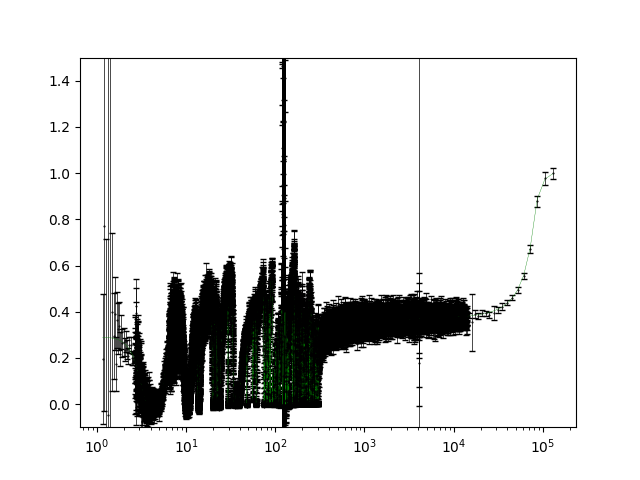

In [54]:
figure()
plt.errorbar(odat.E,Tn, yerr=dT,color='k',ecolor='k',elinewidth=0.5,capsize=2, fmt='.', ms=1)
#plt.scatter(tof, Tn, label='Experimental', s=1, c='k')
plt.plot(odat.E, T_theo, label='Theoretical', c='g', lw=0.25)
#plt.legend()
plt.ylim([-.1,1.5])
# #plt.xlim([1e2,1e3])
plt.xscale('log')
#plt.yscale('log')